# Bike Sharing: Predicción de Demanda Horaria

Para esta sección se simulará el participar en una competencia *Bike Sharing Demand* de *Kaggle*, donde el objetivo será predecir la demanda de bicicletas en la ciudad de Washington, la cual tiene un comportamiento no lineal y no determinista como función de la hora del día.  
En base a esto se ajustarán distintos modelos para ir mejorando en el puntaje obtenido (*score*) y así avanzar en el top-100 del *leaderboard*. Las filas del dataset corresponden a registros de cada hora de la demanda de bicicletas con datos relevantes para predecir esta demanda, los atributos entregados en el dataset se presentan a continuación.

Atributo|Descripción|Tipo Variable 
--------|-------------|--------------- 
_datetime_|hourly date + timestamp|numérica 
_season_|1 = spring, 2 = summer, 3 = fall, 4 = winter|categórica 
_holiday_|whether the day is considered a holiday|categórica 
_workingday_|whether the day is neither a weekend or holiday|categórica 
_weather_|1: Clear, 2: Cloudy, 3: Light Snow, 4: Heavy Rain|categórica 
_temp_|temperature in Celsius|numérica 
_atemp_|"feels like" temperature in Celsius|numérica 
_humidity_|relative humidity|numérica 
_windspeed_|windspeed|numérica 
_casual_|number of non-registered user rentals initiated|numérica 
_registered_|number of registered user rentals initiated|numérica
_count_|number of total rentals|numérica 

La función para evualar los distintos modelos será la siguiente:  

$$
E_{bikes}(\hat{y},y) = \sqrt{ \frac{1}{n} \sum_i^n (\ln{(y_i+1)} - \ln{(\hat{y} +1)})^2 }
$$

Correspondiente a una medición del error para las predicciones de algun modelo de regresión.

## A) Carga Dataset y Análisis

In [1]:
import pandas as pd
import numpy as np
dftrain = pd.read_csv('datasets/bike_sharing_train.csv')
dfval = pd.read_csv('datasets/bike_sharing_val.csv')
dftest = pd.read_csv('datasets/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df = df.drop('Unnamed: 0',axis=1)

print('\nSummary - dataframe completo:\n')
print(df.describe())
#print df
print "Dimensiones de training set: ",dftrain.shape
print "Dimensiones de validation set: ", dfval.shape
print "Dimensiones de test set: ", dftest.shape
print len(df)

#procesamiento
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])


Summary - dataframe completo:

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.2

En la celda anterior se cargan los datos de entrenamiento y de prueba, mostrándo un resumen del dataset con ciertas métricas estadísticas entregadas por la función $describe()$, para describir el dataset. Esta posee 11 atributos (características) para predecir el target (count), de las cuales, para los atributos categóricos, estas métricas estadísticas no tienen un gran significado debido a que estas están codificadas en intervalos discretos, como por ejemplo *season* y *weather* presentan sus valores enteros discretos entre 1 y 4. Se puede ver que las características numéricas varían en un rango muy distinto entre sí y entre las características categóricas, evidenciado en el promedio y desviación estándar de cada uno. Para la variable a predecir, la demanda de bicicletas varía entre 1 y 977, con media 191 y desviación estándar de 181 por lo que en base a esto se puede verificar que la demanda es bastante variable.  

El primer preprocesamiento es extraer la hora del día desde la característica fecha (*datetime*).  
Para este dataset cada fila simboliza la cuantificación de la demanda en un rango de hora específico, tomando estas mediciones cada 1 hora, por ejemplo si una fila tiene demanda 10 significa que en esa hora se vendieron 10 bicicletas. La cantidad de datos que posee el *training set* es de 6562, el *validation set* de 2177 y el *test set* de 2147. El *training set* corresponde a los registros de la demanda de los primeros 19 días de cada mes por 2 años, siendo el *test set* el registro de la demanda del resto de los 11 días de cada mes por los 2 años.

[13773, 60141, 43002, 53708, 53708, 53708] [27250, 98354, 81833, 96599, 96599, 96599] [33947, 104681, 89197, 100973, 100973, 100973] [27305, 99762, 78460, 93241, 93241, 93241]


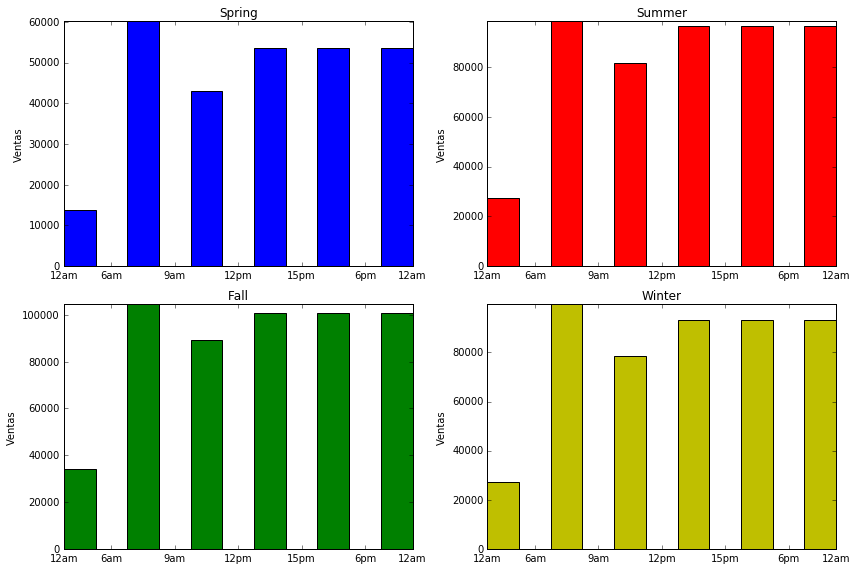

In [2]:
import matplotlib.pyplot as plt

spring_rows1 = df[ (df['season'] == 1) & (df['hour'] <= 6)]
spring_rows2 = df[ (df['season'] == 1) & (df['hour'] > 6) & (df['hour'] <= 9)]
spring_rows3 = df[ (df['season'] == 1) & (df['hour'] > 9) & (df['hour'] <= 12)]
spring_rows4 = df[ (df['season'] == 1) & (df['hour'] > 12) & (df['hour'] <= 15)]
spring_rows5 = df[ (df['season'] == 1) & (df['hour'] > 15) & (df['hour'] <= 18)]
spring_rows6 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]

spring_vals = [sum(spring_rows1['count']),sum(spring_rows2['count']),sum(spring_rows3['count']),sum(spring_rows4['count'])
              ,sum(spring_rows4['count']),sum(spring_rows4['count'])]

summer_rows1 = df[ (df['season'] == 2) & (df['hour'] <= 6)]
summer_rows2 = df[ (df['season'] == 2) & (df['hour'] > 6) & (df['hour'] <= 9)]
summer_rows3 = df[ (df['season'] == 2) & (df['hour'] > 9) & (df['hour'] <= 12)]
summer_rows4 = df[ (df['season'] == 2) & (df['hour'] > 12) & (df['hour'] <= 15)]
summer_rows5 = df[ (df['season'] == 2) & (df['hour'] > 15) & (df['hour'] <= 18)]
summer_rows6 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]

summer_vals = [sum(summer_rows1['count']),sum(summer_rows2['count']),sum(summer_rows3['count']),sum(summer_rows4['count'])
              ,sum(summer_rows4['count']),sum(summer_rows4['count'])]

fall_rows1 = df[ (df['season'] == 3) & (df['hour'] <= 6)]
fall_rows2 = df[ (df['season'] == 3) & (df['hour'] > 6) & (df['hour'] <= 9)]
fall_rows3 = df[ (df['season'] == 3) & (df['hour'] > 9) & (df['hour'] <= 12)]
fall_rows4 = df[ (df['season'] == 3) & (df['hour'] > 12) & (df['hour'] <= 15)]
fall_rows5 = df[ (df['season'] == 3) & (df['hour'] > 15) & (df['hour'] <= 18)]
fall_rows6 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]

fall_vals = [sum(fall_rows1['count']),sum(fall_rows2['count']),sum(fall_rows3['count']),sum(fall_rows4['count'])
              ,sum(fall_rows4['count']),sum(fall_rows4['count'])]

winter_rows1 = df[ (df['season'] == 4) & (df['hour'] <= 6)]
winter_rows2 = df[ (df['season'] == 4) & (df['hour'] > 6) & (df['hour'] <= 9)]
winter_rows3 = df[ (df['season'] == 4) & (df['hour'] > 9) & (df['hour'] <= 12)]
winter_rows4 = df[ (df['season'] == 4) & (df['hour'] > 12) & (df['hour'] <= 15)]
winter_rows5 = df[ (df['season'] == 4) & (df['hour'] > 15) & (df['hour'] <= 18)]
winter_rows6 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]

winter_vals = [sum(winter_rows1['count']),sum(winter_rows2['count']),sum(winter_rows3['count']),sum(winter_rows4['count'])
              ,sum(winter_rows4['count']),sum(winter_rows4['count'])]

print spring_vals, summer_vals,fall_vals,winter_vals

# Construir histograma -------------------------------------------
#PARA COMPARAR LAS EPOCAS DEL AÑO
f, axarr = plt.subplots(2, 2, figsize=(12,8) )
axarr[0, 0].bar(np.arange(0,6,1), spring_vals, width  = 0.5, align = "center", color = 'b')
axarr[0, 0].set_title('Spring')
axarr[0, 0].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[0, 0].set_xticklabels(('12am','6am','9am','12pm','15pm','6pm','12am'))
axarr[0, 0].set_ylabel('Ventas')
axarr[0, 0].axis('tight')

axarr[0, 1].bar(np.arange(0,6,1), summer_vals, width  = 0.5, align = "center", color = 'r')
axarr[0, 1].set_title('Summer')
axarr[0, 1].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[0, 1].set_xticklabels(('12am','6am','9am','12pm','15pm','6pm','12am'))
axarr[0, 1].set_ylabel('Ventas')
axarr[0, 1].axis('tight')

axarr[1, 0].bar(np.arange(0,6,1), fall_vals, width  = 0.5, align = "center", color = 'g')
axarr[1, 0].set_title('Fall')
axarr[1, 0].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[1, 0].set_xticklabels(('12am','6am','9am','12pm','15pm','6pm','12am'))
axarr[1, 0].set_ylabel('Ventas')
axarr[1, 0].axis('tight')

axarr[1, 1].bar(np.arange(0,6,1), winter_vals, width  = 0.5, align = "center", color = 'y')
axarr[1, 1].set_title('Winter')
axarr[1, 1].set_xticks([-0.25,0.5,1.5,2.5,3.5,4.5,5.25])
axarr[1, 1].set_xticklabels(('12am','6am','9am','12pm','15pm','6pm','12am'))
axarr[1, 1].set_ylabel('Ventas')
axarr[1, 1].axis('tight')

f.tight_layout() #separar los subplot
plt.show()

Los gráficos anteriores son presentados para resumir el comportamiento de la demanda (Ventas) en función de distintos rangos de horas (12am a 6am, 6am a 9am y así), para distintas épocas del año. Se ve que estas son distintas, ya que a pesar que los gráficos sean parecidos, estos varían en un distinto rango. Otoño posee la mayor demanda y en Primavera se produce la menor. El comportamiento similar sobre las distintas epocas del año indica un patrón que podrá ser utilizado por los clasificadores a entrenar.  
Se puede observar además, que en todas las épocas el rango de hora en que se producen más ventas son entre las 6am y las 9am. De la misma forma el rango en que se producen menos ventas es entre las 12am y las 6am, lo que es entendible ya que en la madrugada la mayoría de la gente está durmiendo.

## B) Árbol de regresión

In [7]:
from sklearn.tree import DecisionTreeRegressor as Tree

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))


Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.ix[:,'count']

X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

#Modelo
model = Tree()
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print "SCORE TEST=%f"%score_test

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

print "KAGG EVAL TRAIN =%f"%kagg_train
print "KAGG EVAL VAL =%f"%kagg_val
print "KAGG EVAL TEST =%f"%kagg_test

SCORE TEST=0.704966
KAGG EVAL TRAIN =0.028516
KAGG EVAL VAL =0.546807
KAGG EVAL TEST =0.570878


En la celda anterior se crea la función para evaluar los distintos modelos denominada $eval\_bikemodel()$, la cual en el ejercicio será denotada como **KAGG EVAL**. Además se crea el input set y el output set (X y Y respectivamente) para los distintos *set*, utilizando las características procesadas en la pregunta anterior, es decir, las entregadas y reemplazando el *datetime* por la hora.  
Se ajusta un árbol de regresión para el problema sobre el *training set*, comparando distintas métricas sobre los distintos set, como el *accuracy* sobre el *test set* del 70%, la función para evaluar el error para este problema (**KAGG EVAL**) sobre el *validation set* del 55,4% y sobre el *test set* 57,4%. Se puede ver que las métricas difieren (siendo el error, según el *accuracy*, sobre el *test set* del 30%), debido a la forma distinta de medir el error para **KAGG EVAL**, aplicando logaritmo sobre la demanda (*target*) produciendo esta medición del error mayor y más significativa. Respecto a los score *KAGG* reflejan lo esperado de que el error sobre el *training set* es el menor, y que el error sobre el *validation set* y *test set* son cercanos debido a que uno predice al otro.

Al tener una medición del *score KAGG* sobre el *test set* del **57,0%** nos deja en un una posición mayor al 2140 en la competencia.

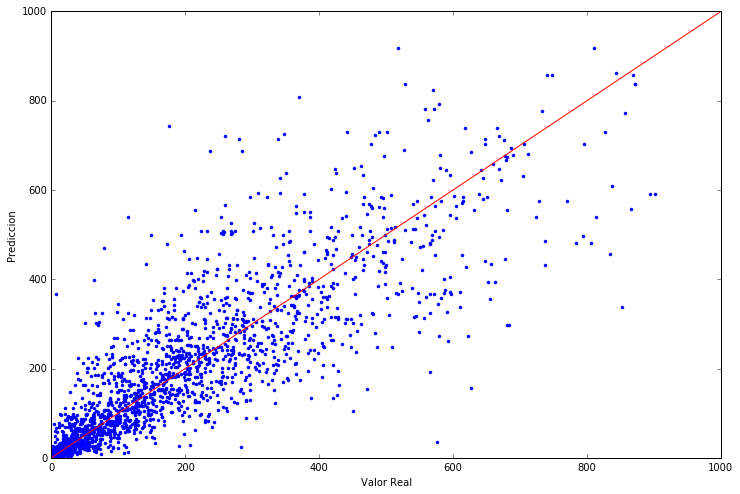

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(1000),range(1000), color ="r")
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

En base a este gráfico donde se puede comparar las predicciones del árbol de regresión versus los valores reales del *test set* (puntos azules), y la línea roja que representa la predicción exacta. Se puede ver que la predicción es bastante buena para algunos casos, presentándose *outliers* en la predicción para otros. Además de ver que las predicciones (puntos azules) están cercanos en rango a la línea roja, pero dispersos en el espacio, mostrándose el error en su lejanía a esta, teniendo una gran cantidad de error (alrededor del 30% como lo calculado anteriormente).

## C) Árbol de regresión - variando hiperparámetros

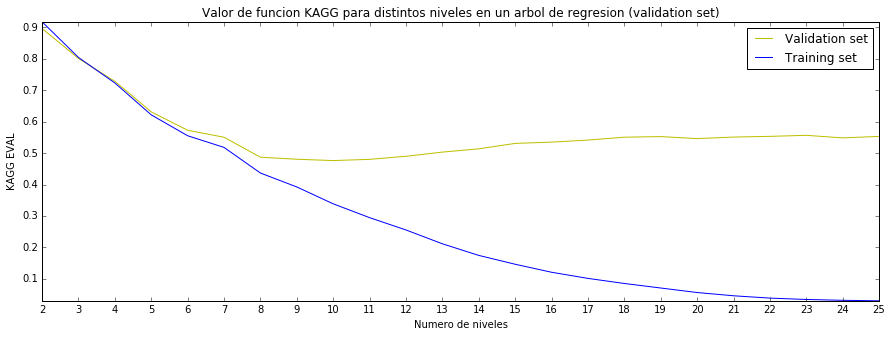

In [9]:
kaggs_val = []
kaggs_train = []
N_ts = np.arange(2,26)
for n_t in N_ts:
    model = Tree(random_state=0,max_depth=n_t)
    model.fit(X_train,Y_train)

    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kaggs_val.append(kagg_val)
    
    Y_pred_train = model.predict(X_train)
    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kaggs_train.append(kagg_train)

plt.figure(figsize=(15,5))    
plt.plot(N_ts,kaggs_val , label  = "Validation set", color = "y")
plt.plot(N_ts,kaggs_train, label = "Training set", color = "b")
plt.xticks(N_ts)
plt.xlabel('Numero de niveles')
plt.ylabel('KAGG EVAL')
plt.title('Valor de funcion KAGG para distintos niveles en un arbol de regresion (validation set)')
plt.legend()
plt.axis("tight")
plt.show()

En la celda anterior se presenta un gráfico que muestra cómo evoluciona la función de evaluación **KAGG** en función del número máximo de niveles permitidos para un árbol de regresión. Se puede ver que a medida que aumenta el número de niveles (2-8) disminuyen tanto el error sobre el *validation set* como sobre el *test set*, donde luego desde el nivel 8 en adelante el error sobre el *validation set* se mantiene y sobre el *training set* disminuye, produciéndose un claro *overfitting*. Esto muestra que un árbol con poca profundidad (podado) generaliza, no llegando a tener hojas "puras" lo cual sobre ajustaría el modelo.  
Para este caso se escoge una profundidad máxima de 10 niveles para el árbol de regresión ajustado en la siguiente celda.

In [10]:
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "KAGG EVAL TEST =%f"%kagg_test

KAGG EVAL TEST =0.516396


Con el árbol de regresión ajustado anteriormente con una máxima profundidad de 10 niveles se tiene un modelo con **KAGG EVAL** sobre el *test set* del **51,6%**, lo cual mejora un 5% al árbol de regresión sin máxima profundidad definido anteriormente. Con esta medición se avanza alrededor de unas 300 posiciones en el *leaderboard*, lo cual es lo esperado debido a que un árbol con una baja *máxima profundidad* no produce sobre ajuste a los datos con los que se entrena, produciendo un regresor más genérico.

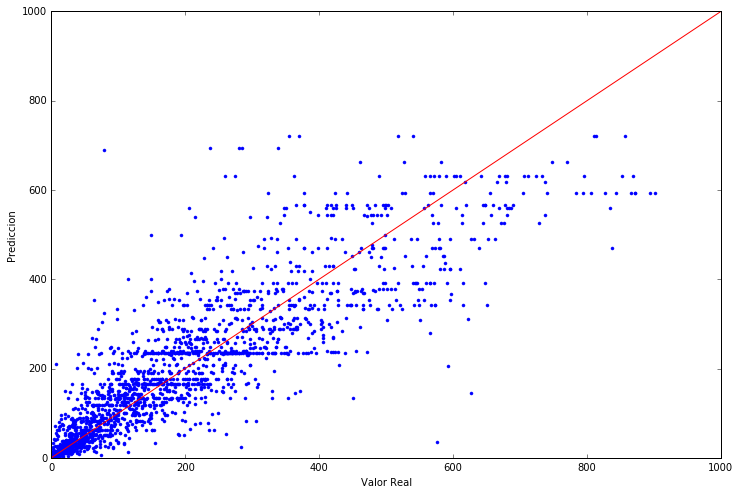

In [11]:
plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(1000),range(1000), color ="r")
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

Comparando este gráfico con el anterior, se logra una levemente mejora que no es visualizable en gran medida. Las predicciones están levemente más cercanas al valor real (línea roja).

## D) Árbol de regresión - variando representación

In [13]:
#procesamiento de fecha(datetime-timestamp) a numeros
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])

df['month'] = pd.to_datetime(df['datetime']).dt.month#1:enero, 12: diciembre
df['month'] = pd.to_numeric(df['month'])

once = df[ (df['year'] == 2011)]
print "year 2011 total demand: ", sum(once['count'])
donce = df[ (df['year'] == 2012)]
print "year 2012 total demand: ",sum(donce['count'])

year 2011 total demand:  781979
year 2012 total demand:  1303497


En la celda anterior se extraen datos desde el *datetime* para tener una mejor representación del modelo de regresión y así mejorar el score obtenido hasta el momento. Se extrae el "cday" correspondiente al día de la semana codificado de 0 a 6, desde lunes a domingo respectivamente. Otro atributo que se extrae de la fecha es el año en que fueron realizado los distintos registros de datos y finalmente el mes del mismo, codificado desde 1 a 12 (enero a diciembre).

In [14]:
def fss(x, y, xval,yval, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)+1
    names_x = np.array(names_x)
    remaining = range(0, p+1)
    selected = []
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = Tree(max_depth = 10)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            x_val = xval[:,indexes]
            
            predictions_val = model.fit(x_train, y).predict(x_val)
            kagg_val = eval_bikemodel(predictions_val,yval) #en base al evaluador kagg
            
            score_candidates.append((kagg_val, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop() #el de menor error es el mejor candidato
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
    return selected

names_features = ['season','holiday','workingday','weather','temp','atemp',
    'humidity','windspeed','hour','cday','month','year']
Xdf=df.ix[:,names_features]
Ydf=df.ix[:,'count'] 
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
        
new_names_features = fss(X_train,Y_train,X_val,Y_val,names_features)[:8]
#mostrar cuales se eliminaron
new_names_features = np.array(names_features)[new_names_features]
print "se eliminaron"
x = set(names_features)
y = x - set(new_names_features)
print y

selected = hour ...
selected = cday ...
selected = season ...
selected = year ...
selected = month ...
selected = holiday ...
selected = workingday ...
selected = weather ...
selected = atemp ...
selected = humidity ...
selected = temp ...
selected = windspeed ...
se eliminaron
set(['windspeed', 'atemp', 'temp', 'humidity'])


Debido a que se añaden más características, es necesario filtrar algunas de estas para ver el efecto, es por esto que en la celda anterior se ocupa **FSS** para determinar cuáles son las características más influyentes para el problema según un modelo de árbol de regresión con 10 niveles como máximo. Se filtran, a partir de este algoritmo, 4 características ("windspeed", "atemp", "temp", "humidity") eliminando estas del modelo regresor, es decir, se eliminn los atributos nuḿericos, dejando únicamente las categóricas.  
Finalmente, se obtienen 3 tipos de representaciones en base a las características en el modelo de regresión, sumado a la posible normalización del *input set* y una transformación al *output* (demanda), propuesto a continuación, se presentan finalmente 12 tipos posibles de representaciones.

Nombre|Características|Normalizado|Transformacion(y)
------|---------------|-----------|--------------
old|season, holiday, workingday, weather, temp, atemp, humidity,windspeed, hour|  X | X
all|old + **cday**, **month**, **year** | X | X 
extract|season, holiday, workingday, weather, hour, cday,month, year|X|X|
-|-|-|-

In [21]:
#print df2
print "---------------------------------------------"
names_features = ['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour','cday','month','year']
df2 = df.ix[:,names_features+['count']]


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
def representacion(df, features,scaler,vector=False):
    if features == "all":
        names_features = ['season','holiday','workingday','weather','temp','atemp',
                            'humidity','windspeed','hour','cday','month','year']
    elif features == "old":
        names_features = ['season','holiday','workingday','weather','temp','atemp',
                            'humidity','windspeed','hour']
    elif features == "extract":
        names_features = ['season','holiday','workingday','weather','hour','cday','month','year']

    #se procesan las caract
    Xdf=df.ix[:,names_features]
    
    if vector: #para representacion vectorial de variables categoricas que no son 0 y 1
        all_categorical_features = ['season','weather','temp','hour','cday','month']
        x = set(all_categorical_features)
        categorical_features = x.intersection(names_features)

        Xdf = pd.get_dummies(Xdf,columns=categorical_features) #categorizar las caract
    
    #se crean las matrices
    Ydf=df.ix[:,'count'] #no se normaliza
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values
        
    #se escala
    if scaler == "standar":
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val = scaler.fit_transform(X_val)
        
        return X_train,Y_train,X_val,Y_val,X_test,Y_test
            
    elif scaler == "normal":
        return X_train, Y_train, X_val, Y_val,X_test,Y_test
    return 0
   
print "representacion no normalizada de las viejas caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"old","normal")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "representacion normalizada de las viejas caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"old","standar")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print "---------------------------------------------"

print "representacion no normalizada de todas las caracteristicas"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"all","normal")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "representacion normalizada de todas las caracteristicas"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"all","standar")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "---------------------------------------------"
print "representacion no normalizada con extraccion de caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")
model = Tree(random_state=0,max_depth=10) 
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "representacion normalizada con extraccion de caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar")
model = Tree(random_state=0,max_depth=10) 
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "---------------------------------------------"
print "representacion normalizada con extracion de caracteristicas y transformar la respuesta"
X_train,Y_train,X_val,Y_val, X_test,Y_test = representacion(df2,"extract","standar")

#transforma la respuesta (Target)
Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)
        
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train) #ajusta el modelo con target normalizado
Y_pred_val = model.predict(X_val)

#volver a la variable original
Y_val = np.exp(Y_val)-1
Y_pred_val = np.exp(Y_pred_val)-1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

---------------------------------------------
representacion no normalizada de las viejas caracteristicas
KAGG EVAL VAL =0.476274
representacion normalizada de las viejas caracteristicas
KAGG EVAL VAL =0.477858
---------------------------------------------
representacion no normalizada de todas las caracteristicas
KAGG EVAL VAL =0.406954
representacion normalizada de todas las caracteristicas
KAGG EVAL VAL =0.407576
---------------------------------------------
representacion no normalizada con extraccion de caracteristicas
KAGG EVAL VAL =0.393547
representacion normalizada con extraccion de caracteristicas
KAGG EVAL VAL =0.396293
---------------------------------------------
representacion normalizada con extracion de caracteristicas y transformar la respuesta
KAGG EVAL VAL =0.402794


En la celda anterior se ajusta un árbol de regresión de 10 niveles para las distintas representaciones creadas para el problema, eligiendo la representación que se ajusta mejor al score **KAGG EVAL** para el *validation set*, un error del 39,3% para la representación con el *input set* no normalizado y extrayendo características del modelo de regresión en base a la importancia según el algoritmo **FSS** para el árbol de regresión.

In [22]:
print "representacion no normalizada con extraccion de caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")
model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "KAGG EVAL TEST =%f "%kagg_test

representacion no normalizada con extraccion de caracteristicas
KAGG EVAL TEST =0.413617 


En base a la representación elegida según el mejor score sobre el *validation set*, correspondiente a la representación no normalizada de los datos con extracción de características, entrega un score **KAGG EVAL** sobre el *test set* del **41,4%**, mejorando el score de la pregunta anterior donde se varió únicamente la cantidad de niveles del árbol de regresión, es decir, el cambio de representación benefició al modelo. Con esto se entra en el top 1000 de la competencia.  
Se espera que la representación de las características dejadas en el modelo según la extracción no estén normalizadas debido a que la mayoría son categóricas, por lo que tienen un mayor significado para el árbol de decisión codificadas con números discretos.

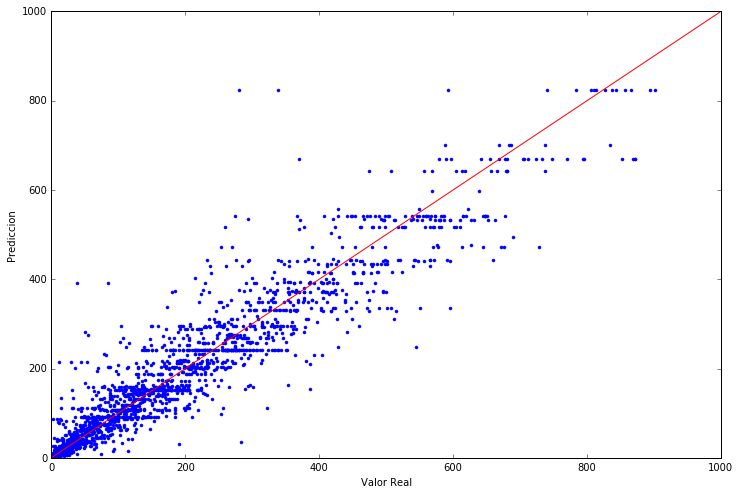

In [23]:
plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(1000),range(1000), color ="r")
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

En este gráfico es mas notable la mejora que se produce con la representación adecuada de los datos del modelo regresor, el árbol de regresión logra que las predicciones (puntos azules) varíen en un rango mas cercano a los valores reales (línea roja) comparado con los anteriores. Las métricas de error también reflejan este resultado.

## E) SVM no lineal - distintas representaciones

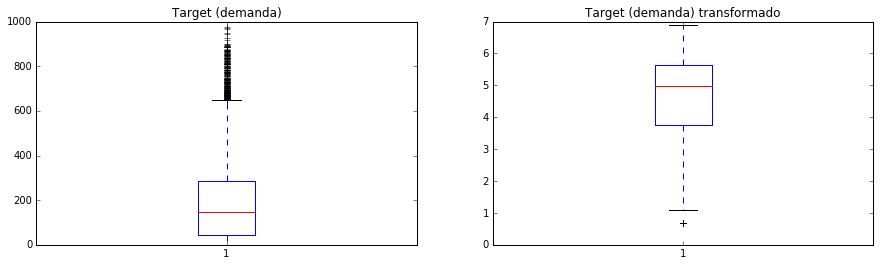

In [99]:
Y = df.ix[:,'count']
Ytransform = np.log(Y+1)

f, ax = plt.subplots(1,2 ,figsize=(15,4))
ax[0].boxplot(Y)
ax[0].set_title('Target (demanda)')
ax[1].boxplot(Ytransform)
ax[1].set_title('Target (demanda) transformado')
plt.show()

En la celda anterior se pueden ver boxplots del target (demanda) de los valores entregados por defecto (izquierda) y aplicando logaritmo natural a los valores entregados por defecto (derecha). Estos gráficos representan que para los valores de la demanda entregados por defecto presenta una gran cantidad de *outliers*, es decir, valores atípicos comparados con todos los valores que se tienen en la muestra entregada (dataset). Para esto se puede aplicar una transformación adecuada al target, normalizando los valores y eliminando todos los *outliers*, esta transformación está inspirada en la función de evaluación **KAGG** y será muy util para el regresor SVM a continuación.

In [33]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"all","standar",vector=True)
print "representacion normalizada de todas las caracteristicas y transformar el Y(target)"
#transformar el Y
Y_train = np.log(Y_train+1)
        
# Se ajusta a modelo SVR
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

#volver a la variable original
Y_train = np.exp(Y_train)-1
Y_pred_val = np.exp(Y_pred_val) -1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print "-------------------------------------------------------"

X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"all","standar",vector=True)
print "representacion normalizada con todas las caracteristicas"

# Se ajusta a modelo SVR
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val
print "-------------------------------------------------------"

X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
print "representacion normalizada con extraccion de caracteristicas y transformar el Y(target)"
#transformar el Y
Y_train = np.log(Y_train+1)
        
# Se ajusta a modelo SVR
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)

#volver a la variable original
Y_train = np.exp(Y_train)-1
Y_pred_val = np.exp(Y_pred_val) -1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

representacion normalizada de todas las caracteristicas y transformar el Y(target)
KAGG EVAL VAL =0.386837
-------------------------------------------------------
representacion normalizada con todas las caracteristicas
KAGG EVAL VAL =1.255825
-------------------------------------------------------
representacion normalizada con extraccion de caracteristicas y transformar el Y(target)
KAGG EVAL VAL =0.320551


Para este caso se ajusta un modelo *SVM* no lineal intentando mejorar el score del árbol de regresión definido anteriormente. En primer lugar se realiza una representación especial para este caso donde las variables categóricas, que no varían entre 1 y 0 , son transformadas en un vector binario donde va un 1 si es en ese caso. Por ejemplo para la variable "season", esta será dividida en 4 vectores binarios simbolizando las 4 estaciones del año, en este caso si la "season" es *fall*  tendrá un uno en el vector binario que corresponda a la "season" *fall* y un cero en las otras.  
Otro factor importante es que es necesario un escalamiento de los datos (*input* y *output*) para tener rangos comparables y tener una mejor predicción. Como se ve en los resultados de la celda anterior si es que el *output* (target) no es transformado, el modelo *SVM* logra predecir el modelo de una manera muy escasa, obteniendo un error **KAGG EVAL** del 125%. Para esto se realiza una transformación al *output* de la misma manera que la función **KAGG EVAL**, es decir aplicando logaritmo natural más uno al valor a transformar, para luego invertir esta operación cuando se evalúa el *score*. Esta transformación es requerida ya que los valores de la demanda son bastante altos (hasta 977 como se vio en la letra *a*) ), reduciendo el rango en el que varía estando continuamente entre 0 y 7 aproximadamente, además se eliminan los *outliers* como se ve en los boxplots anteriores.

Se elige la representación con menor error de **KAGG EVAL** sobre el *validation set*, la cual es la que normaliza el *input set* con la representación extrayendo características y transformando el target, un score del 32%.

In [34]:
print "representacion normalizada con extraccion de caracteristicas y transformar el Y"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
#transformar el Y
Y_train = np.log(Y_train+1)
        
# Se ajusta a modelo SVR
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)

#volver a la variable original
Y_train = np.exp(Y_train)-1
Y_pred_test = np.exp(Y_pred_test)-1

kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "KAGG EVAL TEST =%f "%kagg_test

representacion normalizada con extraccion de caracteristicas y transformar el Y
KAGG EVAL TEST =0.343653 


Con esta representación elegida según el *validation set* se logra un score *KAGG EVAL* sobre el *test set* del **34,4%**, utilizando los hiperparámetros por defectos de la *SVM*. Entrando ya en el top 10 del *leaderboard*.

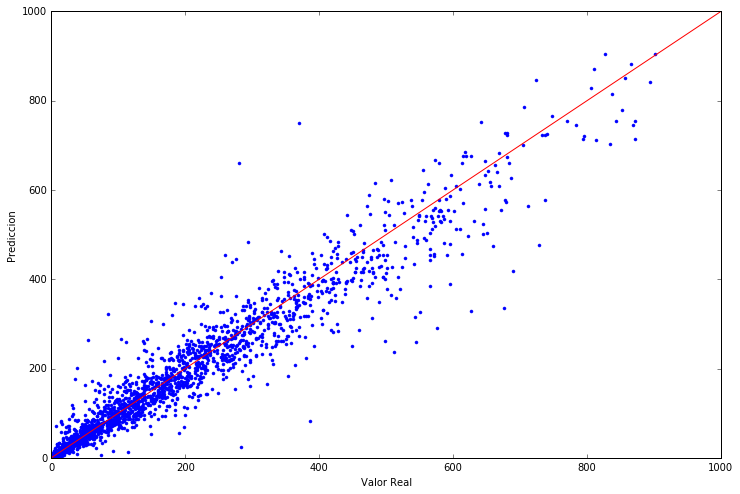

In [35]:
plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(1000),range(1000), color ="r")
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

Comparando este gráfico con los anteriores se puede ver que para este caso la variación alrededor de los valores reales (línea roja) es bastante menor, reflejado también en la baja medición del error calculado anteriormente.

## F) SVR (regresion) no lineal - variación de hiperparámetros

In [18]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)
print "representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)"

# Se ajusta a modelo SVR
from sklearn.svm import SVR
Cs = [0.001,0.01,0.1,1,10,100]
es = [0.001,0.01,0.1,1,10]
info = []
for c in Cs:
    subinfo=[]
    for e in es:
        #transformar el Y
        Y_train = np.log(Y_train+1)
        Y_val = np.log(Y_val+1)

        model = SVR(C=c, epsilon=e)
        model.fit(X_train,Y_train)
        Y_pred_val = model.predict(X_val)

        #volver a la variable original
        Y_train = np.exp(Y_train) -1
        Y_val = np.exp(Y_val) -1
        Y_pred_val = np.exp(Y_pred_val) -1

        #kagg_train = eval_bikemodel(Y_pred_train,Y_train)
        kagg_val = eval_bikemodel(Y_pred_val,Y_val)
        subinfo.append(kagg_val)
    info.append(subinfo)
print info

representacion con extraccion de caracteristicas normalizadas y transformar el Y(target)
[[1.4082932660716465, 1.4084854078286415, 1.408290320311923, 1.3880066416156127, 1.6644681370370946], [1.0976059992374543, 1.0981263092264608, 1.0992643686290147, 1.1654884610229708, 1.6644681370370946], [0.45048495053006765, 0.45043817619250492, 0.45176715859134409, 0.77451963138845348, 1.6644681370370946], [0.3214669929108584, 0.32094457559331713, 0.32055055323835274, 0.6757385160570123, 1.6644681370370946], [0.36565862478440092, 0.3644692642586706, 0.35770076731199224, 0.66641216203463538, 1.6644681370370946], [0.39752891182952899, 0.3949076073807552, 0.37599482786505783, 0.66641216203463416, 1.6644681370370946]]


In [19]:
fila1 = ['C/Epsilon']+es
filas = [[Cs[i]]+info[i] for i in range(len(info))]
table = [fila1]+filas
from tabulate import tabulate
print tabulate(table,   tablefmt="rst")

=========  ========  ========  ========  ========  ========
C/Epsilon  0.001     0.01      0.1       1         10
0.001      1.40829   1.40849   1.40829   1.38801    1.66447
0.01       1.09761   1.09813   1.09926   1.16549    1.66447
0.1        0.450485  0.450438  0.451767  0.77452    1.66447
1          0.321467  0.320945  0.320551  0.675739   1.66447
10         0.365659  0.364469  0.357701  0.666412   1.66447
100        0.397529  0.394908  0.375995  0.666412   1.66447
=========  ========  ========  ========  ========  ========


Para estas celdas se ajusta un modelo *SVM* no lineal con kernel "RBF" variando los hiperparámetros de esta y con la representación adecuada (*input* normalizado, atributos categóricos en vector binario y transformación al target). En la tabla anterior se presentan los distintos scores de la función **KAGG EVAL** en el *validation set*. En la columna de la izquierda se ve cómo varía el hiperparámetro *C*, en la primera fila se ve cómo varía el hiperparámetro $\epsilon$.  
Se puede ver que para valores altos de $\epsilon$ el error aumenta, y para valores pequeños de *C* también, visualizado en la parte superior derecha (diagonal superior) de la tabla. Para valores pequeños de *C* el modelo *SVM* se relaja, penalizando menos y permitiendo un mayor error sobre el *training set*.  

El menor error sobre el *validation set* se produce en el centro de la tabla, con los hiperparámetros configurados en 1 y 0.1 para *C* y $\epsilon$ respectivamente, siendo un valor de 32,1% de error, utilizando esta configuración de parámetros para predecir el *test set* a continuación.

In [ ]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)

#transformar el Y
Y_train = np.log(Y_train+1)

model = SVR(C=1, epsilon=0.1)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)

#volver a la variable original
Y_pred_test = np.exp(Y_pred_test) -1
Y_train = np.exp(Y_train)-1

kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "KAGG EVAL TEST =%f "%kagg_test

KAGG EVAL TEST =0.343653 


Se puede ver que este error es el mismo que para los parámetros por defecto, esto es ya que los parámetros seteados son los por defecto, siendo esa la mejor configuración para ajustar a este problema una *SVM* no lineal con la representación dada.

## G) Cross-validation

In [40]:
from sklearn import cross_validation

def cross_validation_fun(X_train,Y_train,model):
    k_fold = cross_validation.KFold(len(X_train)-2,10)
    score_cv = 0
    for k, (train, val) in enumerate(k_fold):
        #model = ) #SVR(C=1,epsilon=0.1)
        aux_model = model
        aux_model.fit(X_train[train], Y_train[train])
        Ypred_val = aux_model.predict(X_train[val])
        Ytrue_val = Y_train[val]
        score_fold = eval_bikemodel(Ypred_val,Ytrue_val)
        score_cv += score_fold
    score_cv = score_cv / 10
    return score_cv

def cross_validation_svm(X_train,Y_train,model):
    k_fold = cross_validation.KFold(len(X_train)-2,10)
    score_cv = 0
    for k, (train, val) in enumerate(k_fold):
        aux_model = model
        aux_model.fit(X_train[train], Y_train[train])
        Ypred_val = aux_model.predict(X_train[val])
        Ytrue_val = Y_train[val]
        
         #volver a la variable original
        Ypred_val = np.exp(Ypred_val) -1
        Ytrue_val = np.exp(Ytrue_val) -1
        score_fold = eval_bikemodel(Ypred_val,Ytrue_val)
        score_cv += score_fold
    score_cv = score_cv / 10
    return score_cv


#añadir X_val a X_train
newX_train = np.concatenate((X_train,X_val))
newY_train = np.concatenate((Y_train,Y_val))


print "*Decision Tree" #mejor representacion para el arbol
print "representacion no normalizada con extraccion de caracteristicas"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")

N = np.arange(1,31)
mejor = 1
mejor_numero = 0
for n in N:
    model = Tree(random_state=0,max_depth=n)
    model.fit(X_train,Y_train)    
    val = cross_validation_fun(newX_train,newY_train, model)
    if val < mejor:
        mejor = val
        mejor_numero = n
print "BEST DEPTH = ",mejor_numero


print "*SVM" #mejor representacion para el arbol
print "representacion normalizada con extraccion de caracteristicas y Transformar Y"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)

Cs = [0.001,0.01,0.1,1,10,100]
es = [0.001,0.01,0.1,1,10]
mejor = 1
mejor_numero = []
for c in Cs:
    for e in es:
        #transformar el Y
        newY_train = np.log(newY_train+1)
        model = SVR(C=c, epsilon=e)
        model.fit(newX_train,newY_train)
        val = cross_validation_svm(newX_train,newY_train, model)
        if val < mejor:
            mejor = val
            mejor_numero = [c,e]
        #volver a la variable original
        newY_train = np.exp(newY_train) -1
print "BEST CONFIG C =%f , e =%f "%(mejor_numero[0],mejor_numero[1])

*Decision Tree
representacion no normalizada con extraccion de caracteristicas
BEST DEPTH =  12
*SVM
representacion normalizada con extraccion de caracteristicas y Transformar Y


'"\nX_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)\n\nCs = [0.001,0.01,0.1,1,10,100]\nes = [0.001,0.01,0.1,1,10]\nmejor = 1\nmejor_numero = []\nfor c in Cs:\n    for e in es:\n        #transformar el Y\n        newY_train = np.log(newY_train+1)\n        model = SVR(C=c, epsilon=e)\n        model.fit(newX_train,newY_train)\n        val = cross_validation_svm(newX_train,newY_train, model)\n        if val < mejor:\n            mejor = val\n            mejor_numero = [c,e]\n        #volver a la variable original\n        newY_train = np.exp(newY_train) -1\nprint "BEST CONFIG C =%f , e =%f "%(mejor_numero[0],mejor_numero[1])\n'

In [38]:
print "*Decision Tree"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")
model = Tree(random_state=0,max_depth=12)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "KAGG EVAL TEST =%f "%kagg_test   

*Decision Tree
KAGG EVAL TEST =0.400685 


En la celda anterior se presenta el error sobre el *test set* del árbol de regresión prediciendo su parámetro (máxima profundidad) con el método *cross validation*, este error es **40%**, lo cual es mejor que el error sobre el árbol de regresión prediciendo su parámetro con el *validation set* siendo de 41,4%.  

Para el regresor SVM no se presentan sus scores ya que no terminó de iterar en un tiempo considerable (1 hora), por lo que se presenta el árbol de regresión unicamente.

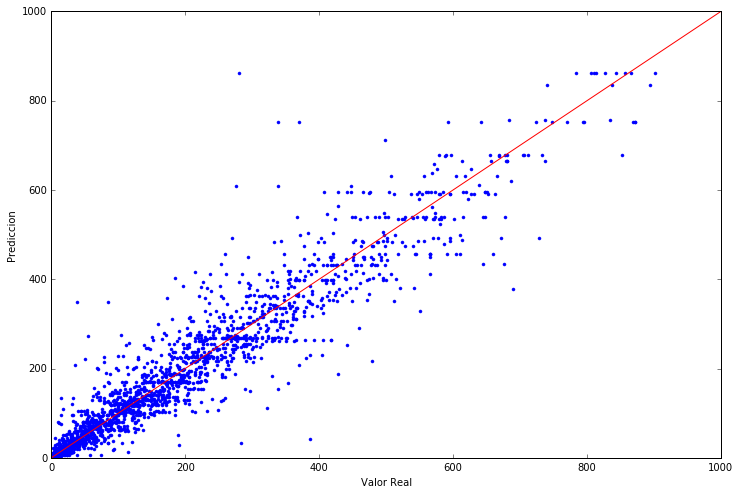

In [42]:
plt.figure(figsize=(12,8))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(1000),range(1000), color ="r")
plt.xlabel('Valor Real')
plt.ylabel('Prediccion')
plt.show()

Este gráfico para las predicciones del árbol de regresión con 12 niveles máximos de profundidad muestra una mejora con respecto al árbol con la selección de la profundidad en base al *validation set*, por lo que esto también corrobora que utilizar *cross validation*, a pesar de lo costoso computacionalmente, es bastante fiable.

## H) Ensamblador (Registered-Casual)

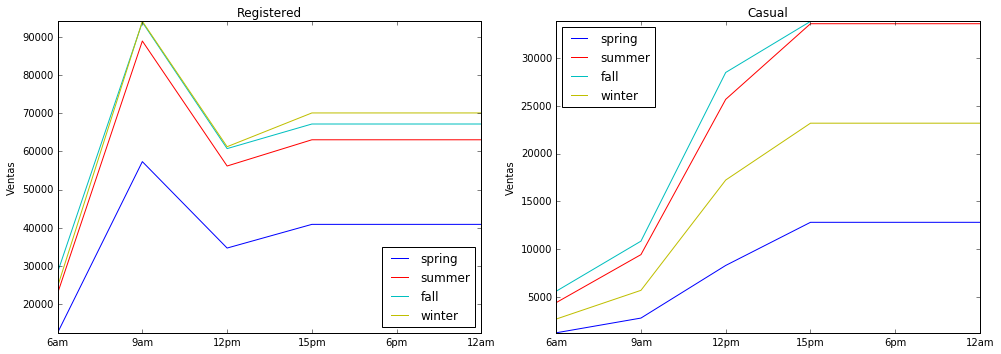

In [43]:
import matplotlib.pyplot as plt

spring_rows1 = df[ (df['season'] == 1) & (df['hour'] <= 6)]
spring_rows2 = df[ (df['season'] == 1) & (df['hour'] > 6) & (df['hour'] <= 9)]
spring_rows3 = df[ (df['season'] == 1) & (df['hour'] > 9) & (df['hour'] <= 12)]
spring_rows4 = df[ (df['season'] == 1) & (df['hour'] > 12) & (df['hour'] <= 15)]
spring_rows5 = df[ (df['season'] == 1) & (df['hour'] > 15) & (df['hour'] <= 18)]
spring_rows6 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]

spring_vals_reg = [sum(spring_rows1['registered']),sum(spring_rows2['registered']),
                   sum(spring_rows3['registered']),sum(spring_rows4['registered'])
                  ,sum(spring_rows4['registered']),sum(spring_rows4['registered'])]
spring_vals_cas = [sum(spring_rows1['casual']),sum(spring_rows2['casual']),
                   sum(spring_rows3['casual']),sum(spring_rows4['casual'])
                  ,sum(spring_rows4['casual']),sum(spring_rows4['casual'])]

summer_rows1 = df[ (df['season'] == 2) & (df['hour'] <= 6)]
summer_rows2 = df[ (df['season'] == 2) & (df['hour'] > 6) & (df['hour'] <= 9)]
summer_rows3 = df[ (df['season'] == 2) & (df['hour'] > 9) & (df['hour'] <= 12)]
summer_rows4 = df[ (df['season'] == 2) & (df['hour'] > 12) & (df['hour'] <= 15)]
summer_rows5 = df[ (df['season'] == 2) & (df['hour'] > 15) & (df['hour'] <= 18)]
summer_rows6 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]

summer_vals_reg = [sum(summer_rows1['registered']),sum(summer_rows2['registered']),
               sum(summer_rows3['registered']),sum(summer_rows4['registered'])
              ,sum(summer_rows4['registered']),sum(summer_rows4['registered'])]
summer_vals_cas = [sum(summer_rows1['casual']),sum(summer_rows2['casual']),
               sum(summer_rows3['casual']),sum(summer_rows4['casual'])
              ,sum(summer_rows4['casual']),sum(summer_rows4['casual'])]

fall_rows1 = df[ (df['season'] == 3) & (df['hour'] <= 6)]
fall_rows2 = df[ (df['season'] == 3) & (df['hour'] > 6) & (df['hour'] <= 9)]
fall_rows3 = df[ (df['season'] == 3) & (df['hour'] > 9) & (df['hour'] <= 12)]
fall_rows4 = df[ (df['season'] == 3) & (df['hour'] > 12) & (df['hour'] <= 15)]
fall_rows5 = df[ (df['season'] == 3) & (df['hour'] > 15) & (df['hour'] <= 18)]
fall_rows6 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]

fall_vals_reg = [sum(fall_rows1['registered']),sum(fall_rows2['registered']),
             sum(fall_rows3['registered']),sum(fall_rows4['registered'])
              ,sum(fall_rows4['registered']),sum(fall_rows4['registered'])]
fall_vals_cas = [sum(fall_rows1['casual']),sum(fall_rows2['casual']),
             sum(fall_rows3['casual']),sum(fall_rows4['casual'])
              ,sum(fall_rows4['casual']),sum(fall_rows4['casual'])]

winter_rows1 = df[ (df['season'] == 4) & (df['hour'] <= 6)]
winter_rows2 = df[ (df['season'] == 4) & (df['hour'] > 6) & (df['hour'] <= 9)]
winter_rows3 = df[ (df['season'] == 4) & (df['hour'] > 9) & (df['hour'] <= 12)]
winter_rows4 = df[ (df['season'] == 4) & (df['hour'] > 12) & (df['hour'] <= 15)]
winter_rows5 = df[ (df['season'] == 4) & (df['hour'] > 15) & (df['hour'] <= 18)]
winter_rows6 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]

winter_vals_reg = [sum(winter_rows1['registered']),sum(winter_rows2['registered']),
               sum(winter_rows3['registered']),sum(winter_rows4['registered'])
              ,sum(winter_rows4['registered']),sum(winter_rows4['registered'])]
winter_vals_cas = [sum(winter_rows1['casual']),sum(winter_rows2['casual']),
               sum(winter_rows3['casual']),sum(winter_rows4['casual'])
              ,sum(winter_rows4['casual']),sum(winter_rows4['casual'])]

# Construir histograma -------------------------------------------

#PARA COMPARAR LAS EPOCAS DEL AÑO
f, axarr = plt.subplots(1,2, figsize=(14,5) )
axarr[0].plot(np.arange(0,6,1), spring_vals_reg, color = 'b', label = "spring")
axarr[0].plot(np.arange(0,6,1), summer_vals_reg, color = 'r', label = "summer")
axarr[0].plot(np.arange(0,6,1), fall_vals_reg, color = 'c', label = "fall")
axarr[0].plot(np.arange(0,6,1), winter_vals_reg, color = 'y', label = "winter")
axarr[0].set_xticks(np.arange(0,6))
axarr[0].set_xticklabels(('6am','9am','12pm','15pm','6pm','12am'))
axarr[0].set_title('Registered')
axarr[0].set_ylabel('Ventas')
axarr[0].axis('tight')

axarr[0].legend(loc=4)

axarr[1].plot(np.arange(0,6,1), spring_vals_cas, color = 'b', label = "spring")
axarr[1].plot(np.arange(0,6,1), summer_vals_cas, color = 'r', label = "summer")
axarr[1].plot(np.arange(0,6,1), fall_vals_cas, color = 'c', label = "fall")
axarr[1].plot(np.arange(0,6,1), winter_vals_cas, color = 'y', label = "winter")
axarr[1].set_xticks(np.arange(0,6))
axarr[1].set_xticklabels(('6am','9am','12pm','15pm','6pm','12am'))
axarr[1].set_title('Casual')
axarr[1].set_ylabel('Ventas')
axarr[1].axis('tight')

axarr[1].legend(loc=2)

f.tight_layout() #separar los subplot
plt.show()

Para evaluar el efecto de los ensamblados de 2 máquinas de aprendizaje en su intento para predecir la demanda total de bicicletas, se confeccionan dos gráficos que muestran el valor de ventas acumuladas entre 5 rangos horarios, que cubren todas las horas del dia. Uno de los gráficos representa la predicción de demanda por parte de los usuarios registrados (*Registered*) y el otro la predicción de la demanda por parte de los usuarios casuales (*Casual*).

Como se puede observar en el gráfico *Registered*, la acumulación de ventas de este tipo de usuario se produce principalmente entre las 6am y las 9am, y luego las ventas son oscilantes, lo que hace pensar que este tipo de usuario tiene una rutina más madrugadora.
También se puede observar que la cantidad de ventas es diferente por cada época del año, produciéndose más ventas en **otoño** e **invierno**.

Por el lado del gráfico *Casual*, se puede visualizar que el horario del día en que se realizan las ventas tiene una tendencia ascendente, es decir, a medida que se hace más tarde las ventas tienden a aumentar gradualmente, lo que hace pensar que el comportamiento de este tipo de usuario es comprar en la tarde.
Este gráfico presenta una diferencia con el gráfico anterior, puesto que las épocas del año en que se producen más ventas en este caso son **otoño** y **verano**.

Es importante notar que la escala de ventas de ambos gráficos es diferente, teniendo una mayor dimensión la del gráfico *Registered*, registrando una acumulacion de ventas por sobre los 90.000, a diferencia de *Casual* que llega a valores del orden de los 30.000.
Esto concuerda con lo esperado, ya que los usuarios registrados tienden a efectuar compras de manera periódica, versus los usuarios casuales que realizan compras de vez en cuando.

In [47]:
Y=df.ix[:,['count','registered','casual']] #demanda total
#print Y

def do_ensambler(df,Y,model1,model2):
    # ------------------ Demanda Registrada ---------------------------
    Yreg=Y.ix[:,'registered']     
    Yreg_train = Yreg[0:ntrain].values.copy()
    Yreg_val = Yreg[ntrain:nval].values.copy()
    Yreg_test = Yreg[nval:].values.copy()

    if model1 == "arbol":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df,"extract","normal")
        model = Tree(random_state=0,max_depth=10)
        
    elif model1 == "svm":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df,"extract","standar",vector=True)
        #transformar el Y de entrenamiento
        Yreg_train = np.log(Yreg_train+1)
        
        model = SVR(C=1, epsilon=0.1)
        
    model.fit(X_train,Yreg_train)
    Yreg_pred_val = model.predict(X_val)
    Yreg_pred_test = model.predict(X_test)
    
    if model1=="svm": #volver a variable original
        Yreg_pred_val = np.exp(Yreg_pred_val)-1
        Yreg_pred_test = np.exp(Yreg_pred_test)-1
 
    # ------------------ Demanda Casual ---------------------------
    Ycas=Y.ix[:,'casual'] #demanda casual
    Ycas_train = Ycas[0:ntrain].values.copy()
    Ycas_val = Ycas[ntrain:nval].values.copy()
    Ycas_test = Ycas[nval:].values.copy()
    
    if model2 == "arbol":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df,"extract","normal")
        model = Tree(random_state=0,max_depth=10)
        
    elif model2 == "svm":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df,"extract","standar",vector=True)
        #transformar Y entrenamiento
        Ycas_train = np.log(Ycas_train+1)
        
        model = SVR(C=1,epsilon=0.1)
    
    model.fit(X_train,Ycas_train)
    Ycas_pred_val = model.predict(X_val)
    Ycas_pred_test = model.predict(X_test)
    
    if model2 == "svm": #volver a variable original
        Ycas_pred_val = np.exp(Ycas_pred_val)-1
        Ycas_pred_test = np.exp(Ycas_pred_test) -1

    return Yreg_pred_val+Ycas_pred_val, Yreg_pred_test+Ycas_pred_test



print "**la demanda es definida registered-casual**"
X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","standar",vector=True)

print "Para la combinacion SVM-SVM"
Y_pred_val,Y_pred_test = do_ensambler(df2,Y,"svm","svm")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion SVM-TREE"
Y_pred_val,Y_pred_test = do_ensambler(df2,Y,"svm","arbol")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion TREE-SVM"
Y_pred_val,Y_pred_test = do_ensambler(df2,Y,"arbol","svm")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

print "Para la combinacion TREE-TREE"
Y_pred_val,Y_pred_test = do_ensambler(df2,Y,"arbol","arbol")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print "KAGG EVAL VAL =%f"%kagg_val

**la demanda es definida registered-casual**
Para la combinacion SVM-SVM
KAGG EVAL VAL =0.319178
Para la combinacion SVM-TREE
KAGG EVAL VAL =0.320107
Para la combinacion TREE-SVM
KAGG EVAL VAL =0.358993
Para la combinacion TREE-TREE
KAGG EVAL VAL =0.370031


En la celda anterior se crea un ensamblado ajustando 2 modelos regresores, cada uno ajustado y especializado sobre una parte de la data, esto se produce ya que la data se divide en demanda de usuarios **registrados** y demanda de usuarios **casuales**, por lo que se evalúa el efecto de utilizar este ensamblado donde cada máquina se ajusta a los usuarios registrados o los usuarios casuales. Por ejemplo si se escoge la combinación árbol-svm, el árbol de decisión se ajusta y especializa sobre la demanda de usuarios registrados, por otro lado el svm se ajusta y especializa sobre la demanda de usuarios casuales.  
Distintas combinaciones son presentadas en la celda anterior mostrándo su score del error **KAGG EVAL** sobre el *validation set*, eligiendo la mejor de estas (*SVM-SVM*) para evaluar su score sobre el *test set*.

In [51]:
print "Para la combinacion SVM-SVM"
Y_pred_val,Y_pred_test = do_ensambler(df2,Y,"svm","svm")
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "BEST KAGG EVAL in TEST SET =%f"%kagg_test

Para la combinacion SVM-SVM
BEST KAGG EVAL in TEST SET =0.342514


Se presenta el error sobre el *test set* de un **34,3%**, valor menor que una única svm ajustada sobre todo el dataset (34,4%). Esto es gracias a que un ensamblado presenta un mayor desempeño que una máquina singular debido a que una máquina puede presentar errores que la otra máquina corrige, es por esto que dos máquinas ensamblados una especializándose en una parte de la data entrega un mejor score. Además de que cada parte de la data se comporta de una manera distinta (usuarios registrados vs usuarios casuales) mostrado en el gráfico anterior, por lo que resulta conveniente ajustar 2 máquinas.

## I) Random Forest Regressor

In [80]:
from sklearn.ensemble import RandomForestRegressor

X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")

N = np.arange(1,31)
info1 = []
mejor = 1
mejor_numero = 0
for n_trees in N:
    model = RandomForestRegressor(n_estimators=n_trees,max_depth=10,random_state=0)
    model.fit(X_train,Y_train)    
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)
    
    #para grafico de mas abajo
    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
    info1.append([kagg_train,kagg_test])
    
    val = eval_bikemodel(Y_pred_val,Y_val)
    if val <mejor:
        mejor = val
        mejor_numero = n_trees
print "BEST NUMBER OF TREES = %d"%mejor_numero
print "--------------------------------------------"

N = np.arange(1,31)
info2 = []
mejor = 1
mejor_niveles = 0
for level in N:
    model = RandomForestRegressor(n_estimators=20,max_depth=level,random_state=0)
    model.fit(X_train,Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
    info2.append([kagg_train,kagg_test])
    
    val = eval_bikemodel(Y_pred_val,Y_val)
    if val <mejor:
        mejor = val
        mejor_niveles = level
print "BEST DEEPTH= %d"%mejor_niveles

BEST NUMBER OF TREES = 20
--------------------------------------------
BEST DEEPTH= 13


En la celda anterior se ajusta un modelo *Random Forest Regresor* el cual es un ensamblador de *n* árboles de regresión para este caso. Se varía la cantidad de árboles utilizados en el ensamblado como tambien la cantidad de niveles para obtener el mejor modelo, ajustándose sobre él y tomando la decisión en base al error de la función **KAGG EVAL** sobre el *validation set*. Presentando la mejor configuración de cantidad de árboles en el ensamblado (20) y la máxima profundidad de cada árbol de regresión en el ensamblado (13), se ve el efecto sobre el *test set* a continuación.

In [50]:
print "--------------------------------------------"
model = RandomForestRegressor(n_estimators=20,max_depth=13,random_state=0)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print "BEST KAGG EVAL in TEST SET =%f"%kagg_test

--------------------------------------------
BEST KAGG EVAL in TEST SET =0.370870


El score sobre el *test set* (en base **KAGG EVAL**) es del **37,1%**, este error es mayor que el de la *SVM*, pero menor que el de los árboles de decisión ajustados anteriormente (alrededor del 40%). Con esto se puede ver el poder de un ensamblado de $n$ árboles donde tiene un mayor poder para entregar una buena predicción, comparado con un único árbol. Por otro lado un ensamblado de dos *SVM* se comportó mejor que este caso, por lo que esto nos entrega que para este caso un ensamblado de *árboles* se comporta mejor que un único árbol.

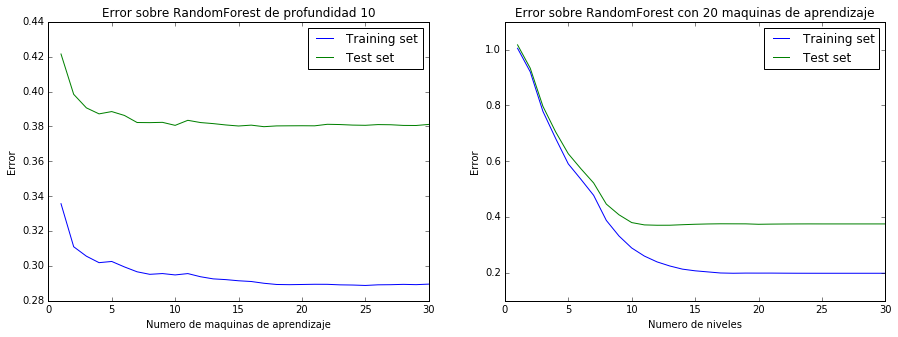

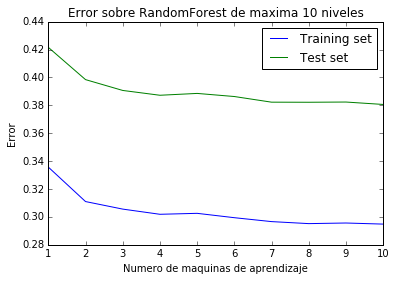

In [91]:
error_train1 = [ i[0] for i in info1]
error_test1 = [ i[1] for i in info1]
error_train2 = [ i[0] for i in info2]
error_test2 = [ i[1] for i in info2]

import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].plot(N,error_train1, label = "Training set")
axarr[0].plot(N,error_test1, label = "Test set")
#axarr[0].set_xticks(N)
axarr[0].set_xlabel('Numero de maquinas de aprendizaje')
axarr[0].set_ylabel('Error')
axarr[0].set_title('Error sobre RandomForest de profundidad 10')
#axarr[0].set_ylim(0,0.5)
axarr[0].legend(loc="upper right")

axarr[1].plot(N,error_train2, label = "Training set")
axarr[1].plot(N,error_test2, label = "Test set")
#axarr[1].set_xticks(N)
axarr[1].set_xlabel('Numero de niveles')
axarr[1].set_ylabel('Error')
axarr[1].set_title('Error sobre RandomForest con 20 maquinas de aprendizaje')
axarr[1].legend(loc="upper right")
plt.show()

plt.plot(N[:10],error_train1[:10], label = "Training set")
plt.plot(N[:10],error_test1[:10], label = "Test set")
#axarr[1].set_xticks(N)
plt.xlabel('Numero de maquinas de aprendizaje')
plt.ylabel('Error')
plt.title('Error sobre RandomForest de maxima 10 niveles')
plt.legend(loc="upper right")
plt.show()

En la celda anterior se ejecuta un algoritmo genérico basado en *Random Forest* para ensamblar máquinas de aprendizaje que predicen la demanda total de bicicletas y así poder generar los gráficos presentados.

En el primer gráfico se presenta el error versus el número de árboles con máxima profundidad 10 utilizados en el ensamblado. Se puede observar que el error registrado por el *training set* y el *test set* presentan valores inferiores a 0.44 lo cual es relativamente bajo.
Se puede apreciar claramente que tanto el *training set* como el *test set* poseen un comportamiento muy similar y uniforme al aumentar el número de máquinas de aprendizaje, por lo que se infiere que no se produce *overffiting*, sino que lo que hace es ir mejorando los árboles utilizados, debido a que el ensamblado combina los árboles produciéndo un mejor resultado.

En el segundo gráfico se ve como evoluciona el error versus el número máximo de niveles de profundidad en un modelo *Random Forest* con 20 máquinas de aprendizaje.
Se puede observar que el error del *training set* y del *test set* decrece rápidamente a medida que aumenta el número de niveles de cada máquina, estabilizándose en ambos casos después de sobrepasar los 10 niveles de profundidad, lo cual concuerda con lo esperado, ya que anteriormente se obtuvo que la profundidad óptima para *Random Forest* con 20 máquinas es de 13 niveles. Para este caso se produce *overfitting* claramente, ya que los errores pasan de estar bastante cercanos a rangos lejanos, disminusyendo el error del *training set* en una mayor medida.

In [89]:
from sklearn.ensemble import AdaBoostRegressor

X_train,Y_train,X_val,Y_val,X_test,Y_test = representacion(df2,"extract","normal")

info_ada =[]
info_bagg = []
for i in range(1,51):
    model = AdaBoostRegressor(Tree(max_depth=10,random_state=0), n_estimators=i, random_state=0)
    model.fit(X_train,Y_train)
    Y_pred_test = model.predict(X_test)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
    info_ada.append(kagg_test)
    
    model = BaggingRegressor(Tree(max_depth=10,random_state=0), n_estimators=i, random_state=0)
    model.fit(X_train,Y_train)
    Y_pred_test = model.predict(X_test)
    kagg_test = eval_bikemodel(Y_pred_test,Y_test)
    info_bagg.append(kagg_test)
print "termino"

termino


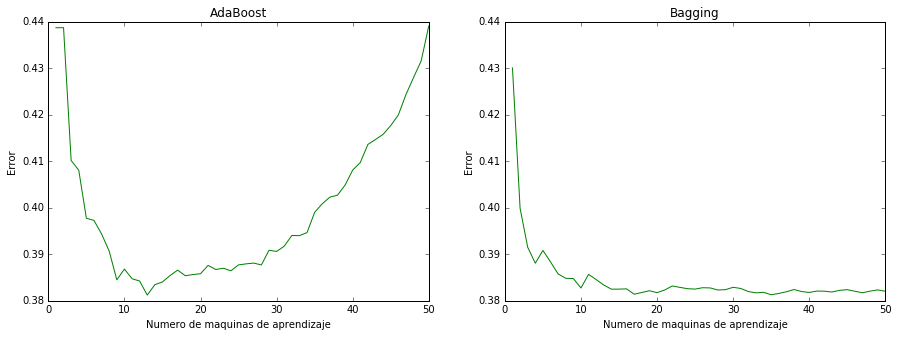

In [93]:
f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range(1,51),info_ada, color = "g")
ax[0].set_xlabel('Numero de maquinas de aprendizaje')
ax[0].set_ylabel('Error')
ax[0].set_title('AdaBoost')
ax[1].plot(range(1,51),info_bagg, color = "g")
ax[1].set_xlabel('Numero de maquinas de aprendizaje')
ax[1].set_ylabel('Error')
ax[1].set_title('Bagging')
plt.show()

En este gráfico se visualiza el error sobre algoritmos para ensamblar máquinas de aprendizaje, donde se puede ver que ambos disminuyen drásticamente el error sobre el *test set* a partir de una única máquina, para luego ir variando este error a medida que se aumenta el número de máquinas. Para Adaboost aumenta el error cona gran cantidad de máquinas, produciendo un exceso de información y para Bagging disminuye oscilante. Para ambos casos se ensamblaron árboles de regresión debido a su poco costo computacional.

Es importante recalcar que para estos dos algoritmos ensambladores y para RandomForest el error disminuye sin sobrepasar al valor 0.38. Esto muestra que para distintos tipos de ensambladores el mayor poder de aprendizaje de estos algoritmos es logrado pero hasta un límite o punto tope para todos, es decir, a pesar de utilizar distintos algoritmos estos no logran disminuir el error del 38%, esto muestra la familiaridad de los distintos algoritmos de ensamblados.